# Setup

## Imports

In [1]:
repo_root, *_ = !git rev-parse --show-toplevel
%cd {repo_root}

/mnt/batch/tasks/shared/LS_root/mounts/clusters/rubchume1/code/Users/rubchume/SalesReinforcer


In [2]:
%load_ext autoreload
import functools
from pathlib import Path
import random

import dateparser
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.evaluation import evaluate_policy

from notebooks.eda_tools.graphs.discrete_feature_binary_target import bar
from src.user_flow_environment import draw_network, UserFlowEnvironment

## Utilities

### Data Loading

In [3]:
from abc import ABC, abstractmethod
from typing import Callable, Generic, TypeVar


T = TypeVar("ResultType")


class Cache(ABC, Generic[T]):
    def __init__(self, recompute):
        self.recompute = recompute
        
    def __call__(self, function):
        def wrapper(*args, **kwargs):
            key = self.key_generator(*args, **kwargs)
            if not self.recompute and self.is_cached(key):
                return self.load(key)
            
            result = function(*args, **kwargs)
            self.save(key, result)
            return result
        
        return wrapper
    
    @abstractmethod
    def key_generator(self, *args, **kwargs) -> str:
        """Generates cache key from input arguments to function"""
        
    @abstractmethod
    def is_cached(self, key: str) -> bool:
        """Checks if cache key exists"""
        
    @abstractmethod
    def save(self, key: str, result: T):
        """Saves the result with the given cache key"""
        
    @abstractmethod
    def load(self, key: str) -> T:
        """Loads the result associated to the given cache key"""

        
date_columns = [
    "First Contact",
    "Last Contact",
    "First Call",
    "Signed up for a demo",
    "Filled in customer survey",
    "Did sign up to the platform",
    "Account Manager assigned",
    "Subscribed"
]
    
    
class DataFrameCsvCache(Cache[pd.DataFrame]):
    def __init__(self, csv_name, recompute=False):
        self.csv_name = csv_name
        super().__init__(recompute)
        
    def key_generator(self, *args, **kwargs) -> str:
        return self.csv_name
        
    def is_cached(self, key: str) -> bool:
        return Path(self.csv_name).is_file()
        
    def save(self, key: str, result: pd.DataFrame):
        result.to_csv(key, index=False)
        
    def load(self, key: str) -> pd.DataFrame:
        df = pd.read_csv(key)
        df[date_columns] = df[date_columns].apply(pd.to_datetime, axis="index")
        return df


In [4]:
def clean_date_format(column):
    null_values = ["0000-00-00", "No"]
    column = column.replace(null_values, None)
    column = column.str.replace("20221", "2021")
    return column


def parse_dates(column: pd.Series):
    column_clean_format = clean_date_format(column)
    return column_clean_format.map(dateparser.parse, na_action="ignore")


def clean_country(countries: pd.Series):
    countries = countries.fillna("Unknown").str.lower().str.strip()
    replacements = [
        ("czechia \(czech republic\)", "czechia"),
        ("bulgaria & uk", "bulgaria"),
        ("-", "unknown"),
        ("ca", "california"),
        ("california", "usa"),
        ("chuang", "china"),
        ("full time", "unknown"),
        ("greek", "greece"),
        ("nottingham", "uk"),
        ("philadelphia", "usa"),
        ("russia&ukraine", "russia"),
        ("vietnamese", "vietnam"),
    ]
    
    return functools.reduce(
        lambda countries, replacement: countries.str.replace(fr"^{replacement[0]}$", replacement[1], regex=True),
        replacements,
        countries
    )


@DataFrameCsvCache("data/SalesCRM - CRM (Clean).csv", recompute=False)
def load_data():
    df = pd.read_csv("data/SalesCRM - CRM.csv")
    df[date_columns] = df[date_columns].apply(parse_dates, axis="index")
    df.Country = clean_country(df.Country)
    df["subscribed"] = (df.Stage == "subscribed already") | (~pd.isnull(df.Subscribed))
    return df

### Data processing

In [5]:
def customer_flow_dates_to_order(customer_flow: pd.Series):
    date_fields_chronologic_order = customer_flow[date_columns].sort_values().dropna().index
    customer_flow = customer_flow.copy()
    customer_flow.loc[date_fields_chronologic_order] = np.arange(len(date_fields_chronologic_order))
    return customer_flow


def compute_connection_matrix(df_order):
    connection_matrix = pd.DataFrame(
        [
            [
                sum(df_order[column_next] == df_order[column] + 1)
                for column_next in df_order.columns
            ] for column in df_order.columns
        ],
        index=df_order.columns,
        columns=df_order.columns
    )
    return (
        connection_matrix
        .rename_axis("origin", axis="index")
        .rename_axis("destination", axis="columns")
    )


def filter_edges(connection_matrix, allowed_edges):
    connection_matrix_filtered = pd.DataFrame(np.zeros(connection_matrix.shape), index=connection_matrix.index, columns=connection_matrix.columns)
    for origin, destinations in allowed_edges.items():
        connection_matrix_filtered.loc[(origin,), destinations] = connection_matrix.loc[(origin,), destinations]
        
    return connection_matrix_filtered


def add_terminated_and_origin_states_to_connection_matrix(connection_matrix, num_users_in_stage):
    def adjust_missing_next_step(next_states):
        origin_state = next_states.name
        next_states = next_states.copy()
        missing = num_users_in_stage[origin_state] - next_states.sum()
        if expect_action[origin_state]:
            next_states[origin_state] = missing
            next_states["Terminated"] = 0
        else:
            next_states["Terminated"] = missing

        return next_states

    def adjust_missing_previous_step(previous_states):
        destination_state = previous_states.name
        previous_states = previous_states.copy()
        missing = num_users_in_stage[destination_state] - previous_states.sum()
        previous_states["Origin"] = missing

        return previous_states

    expect_action = pd.Series([True, False, True, False, False, True, False, False], index=connection_matrix.columns)
    new_connection_matrix = connection_matrix.apply(adjust_missing_next_step, axis="columns")
    num_users_in_stage["Terminated"] = new_connection_matrix["Terminated"].sum()
    new_connection_matrix = new_connection_matrix.apply(adjust_missing_previous_step, axis="index")
    num_users_in_stage["Origin"] = new_connection_matrix.loc["Origin", :].sum()
    new_connection_matrix["Origin"] = 0
    new_connection_matrix.loc["Terminated", :] = 0
    return new_connection_matrix


def create_edge_information(connection_matrix, action_edges):
    def add_actions_and_rewards():
        edge_information["action"] = "Automatic"
        edge_information["reward"] = 0
        for origin, destination, action, reward in action_edges:
            try:
                edge_information.loc[(origin, destination), "action"] = action
                edge_information.loc[(origin, destination), "reward"] = reward
            except Exception:
                pass
            
    edge_information = (
        connection_matrix
        .stack()
        [connection_matrix.stack() > 0]
        .rename("weight")
        .to_frame()
    )
    
    add_actions_and_rewards()

    return edge_information


def edge_info_to_graph(edge_information, node_weights: pd.Series, terminal_states=None):
    node_data = [
        (node, {"weight": weight, "terminal": node in terminal_states}) for node, weight in node_weights.items()
    ]
    G = nx.DiGraph()
    G.add_nodes_from(node_data)
    G.add_edges_from([(origin, destination, row.to_dict()) for (origin, destination), row in edge_information.iterrows()])
    return G

# Import and transform data

In [6]:
df = load_data()

In [7]:
df.head()

ID               Country Education First Contact Last Contact Status Stage  \
0   1               unknown       NaN           NaT          NaT    NaN   NaN   
1   2               austria       NaN           NaT          NaT    NaN   NaN   
2   3  united arab emirates       NaN           NaT          NaT    NaN   NaN   
3   4                france       NaN           NaT          NaT    NaN   NaN   
4   5                   usa       NaN           NaT          NaT    NaN   NaN   

  First Call Signed up for a demo Filled in customer survey  \
0        NaT                  NaT                       NaT   
1 2022-04-28           2022-04-25                2022-04-25   
2        NaT           2022-04-24                       NaT   
3 2022-04-22           2022-04-20                2022-04-20   
4 2022-04-23           2022-04-19                2022-04-19   

  Did sign up to the platform Account Manager assigned Subscribed  subscribed  
0                  2022-04-27                      NaT        NaT       False  
1                  2022-04-25                      NaT        NaT       False  
2                         NaT                      NaT        NaT       False  
3                  2022-04-22               2022-04-22        NaT       False  
4                         NaT                      NaT        NaT       False

# Explore demographic data

## Subscribed by country

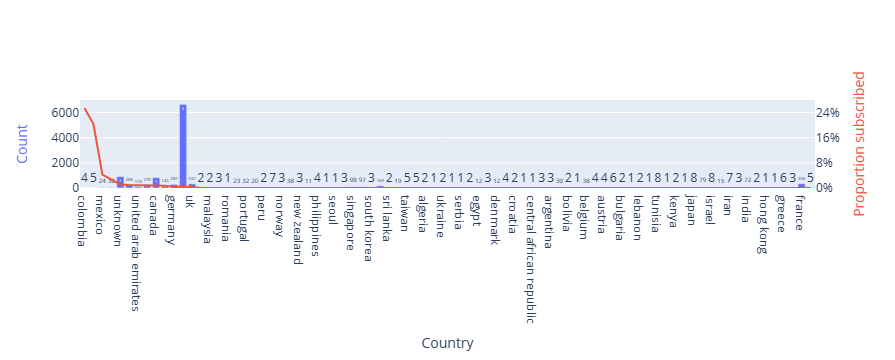

In [8]:
bar(df.Country, df.subscribed, "Country", target_average_name="Proportion subscribed")

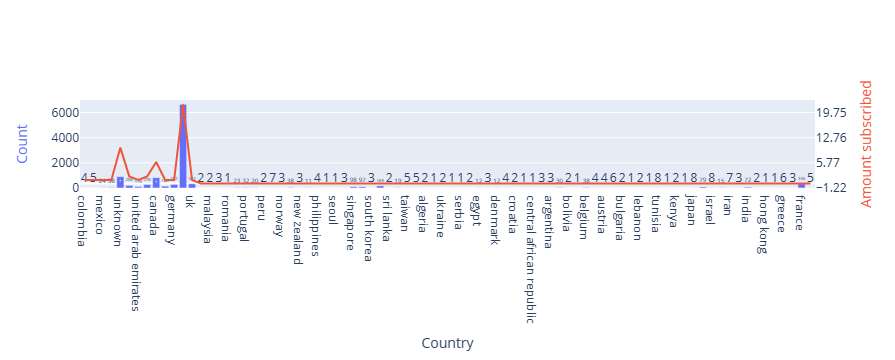

In [9]:
bar(df.Country, df.subscribed, "Country", target_average_name="Amount subscribed", plot_average=False)

## Subscribed by education level

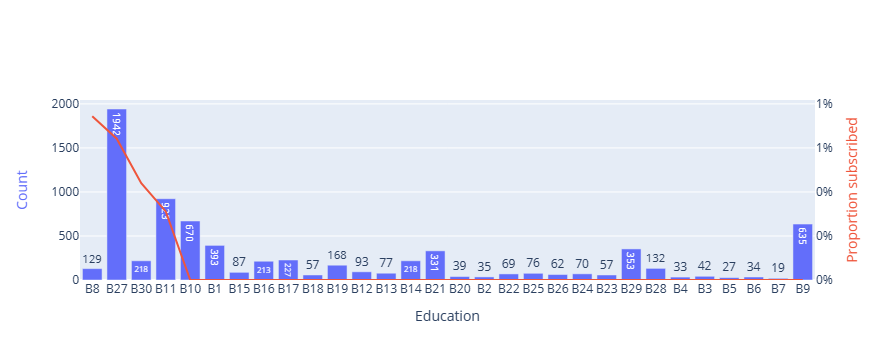

In [10]:
bar(df.Education, df.subscribed, "Education", target_average_name="Proportion subscribed")

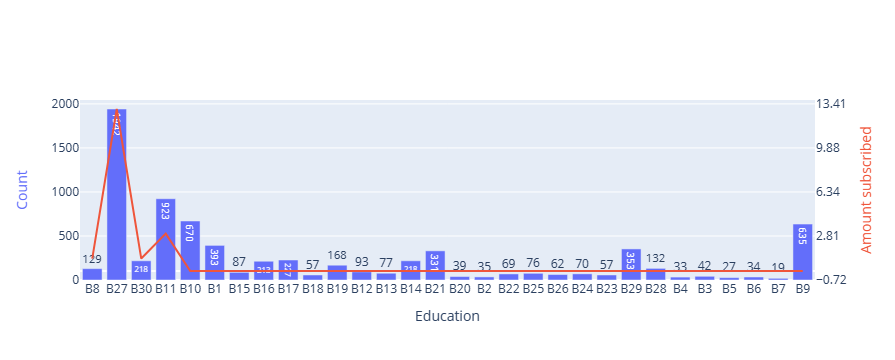

In [11]:
bar(df.Education, df.subscribed, "Education", target_average_name="Amount subscribed", plot_average=False)

# Explore user funnel

Each row represents the sequence a given user has gone through from the first contact with the company to the end of his journey, which can finish in subscribing or abandoning the process.

There are in total 11032 cases to be studied.

In [12]:
df.head()

ID               Country Education First Contact Last Contact Status Stage  \
0   1               unknown       NaN           NaT          NaT    NaN   NaN   
1   2               austria       NaN           NaT          NaT    NaN   NaN   
2   3  united arab emirates       NaN           NaT          NaT    NaN   NaN   
3   4                france       NaN           NaT          NaT    NaN   NaN   
4   5                   usa       NaN           NaT          NaT    NaN   NaN   

  First Call Signed up for a demo Filled in customer survey  \
0        NaT                  NaT                       NaT   
1 2022-04-28           2022-04-25                2022-04-25   
2        NaT           2022-04-24                       NaT   
3 2022-04-22           2022-04-20                2022-04-20   
4 2022-04-23           2022-04-19                2022-04-19   

  Did sign up to the platform Account Manager assigned Subscribed  subscribed  
0                  2022-04-27                      NaT        NaT       False  
1                  2022-04-25                      NaT        NaT       False  
2                         NaT                      NaT        NaT       False  
3                  2022-04-22               2022-04-22        NaT       False  
4                         NaT                      NaT        NaT       False

In [13]:
df.shape

(11032, 14)

We can divide the columns in two types: steps and other information. Step columns are those that contain the day when the user arrived at a given step in the user funnel. If the information is missing, it means that the user never arrived at that step.

For example, from the first row of the dataframe we can know that the user only signed up to the platform and no further contact was made in any case. And from the second row we can know that the first call arrived after signing up to the platform, but subscription was never achieved.

The rest of columns give contextual information as the country of the user or the education level.

In order to visualize how the funnel works, I am going to plot a graph where each node is a step and each edge is the transition from one step to the next. The size of nodes will be bigger the bigger is the amount of users arrived at that step (but not in a lineraly proportional fashion, but a logarithmic one, for aesthetic reasons), and the same with the width of edges.

First, the dates will be used to find the chronological order in which the steps happened and substitute the date by the integer that represents the order (losing time information but not ordinal information). In case multiple steps happened the same day, we will assume they follow a left to right sequencial order, which makes sense (signing up for a demo comes before a survey and then they sign up to the platform, etc.).

In [37]:
df_order = df.apply(customer_flow_dates_to_order, axis="columns")[date_columns]
df_order.head()

First Contact Last Contact First Call Signed up for a demo  \
0           NaT          NaT        NaT                  NaT   
1           NaT          NaT          3                    0   
2           NaT          NaT        NaT                    0   
3           NaT          NaT          2                    0   
4           NaT          NaT          2                    0   

  Filled in customer survey Did sign up to the platform  \
0                       NaT                           0   
1                         1                           2   
2                       NaT                         NaT   
3                         1                           3   
4                         1                         NaT   

  Account Manager assigned Subscribed  
0                      NaT        NaT  
1                      NaT        NaT  
2                      NaT        NaT  
3                        4        NaT  
4                      NaT        NaT

With the order information I can compute a matrix for counting how many users went from step A to step B.

In [14]:
connection_matrix_raw = compute_connection_matrix(df_order)

In [38]:
connection_matrix_raw

destination                  First Contact  Last Contact  First Call  \
origin                                                                 
First Contact                            0         10226          62   
Last Contact                             3             0         229   
First Call                               6            22           0   
Signed up for a demo                     0             1           3   
Filled in customer survey                0             0          54   
Did sign up to the platform              7            41          54   
Account Manager assigned                 1             2           0   
Subscribed                               0             1           1   

destination                  Signed up for a demo  Filled in customer survey  \
origin                                                                         
First Contact                                   1                          0   
Last Contact                                   11                          0   
First Call                                     19                          3   
Signed up for a demo                            0                        181   
Filled in customer survey                       0                          0   
Did sign up to the platform                     3                          0   
Account Manager assigned                        0                          0   
Subscribed                                      0                          0   

destination                  Did sign up to the platform  \
origin                                                     
First Contact                                          3   
Last Contact                                          56   
First Call                                           163   
Signed up for a demo                                   0   
Filled in customer survey                             68   
Did sign up to the platform                            0   
Account Manager assigned                               0   
Subscribed                                             0   

destination                  Account Manager assigned  Subscribed  
origin                                                             
First Contact                                       0           0  
Last Contact                                        0           1  
First Call                                         25           2  
Signed up for a demo                                0           0  
Filled in customer survey                           0           0  
Did sign up to the platform                        36          11  
Account Manager assigned                            0          33  
Subscribed                                         10           0

Some of the connections don't make sense, so they are clearly mistakes at the time of collecting the data. The most obvious example is that there are three rows in which the first contact comes after the last contact, which is logically impossible.

Other connections are proably also mistakes, but they could also be outliers, depending on the assumptions we make since we don't actually know how the process worked in reality in the company. For example, if we assume that "contact" means text contact (email, SMS, etc.), having the first contact after the first call could happen given we don't know more details about how that first call was made (Random selection of telephone numbers from a list? Did the user called the company instead of the other way around?). However, it is unlikely.

And finally there are other connections which are simply not useful to us. For example, once the user has subscribed, we have achieved our goal and it is not so interesting if an account manager was assigned after that event or not.

I have created a list of allowed connections, this is, a list of connections that I have regarded as possible, likely or useful, and assume the rest of them are mistakes, outliers or useless information that are not worth to be included.
Given that we must assume information we don't have, I have chosen to reduce the complexity quite a lot.

In [41]:
allowed_edges = {
    "First Contact": ("Last Contact", "First Call", "Did sign up to the platform", "Subscribed"),
    "Last Contact": ("First Call", "Did sign up to the platform", "Signed up for a demo", "Subscribed"),
    "First Call": ("Last Contact", "Signed up for a demo", "Did sign up to the platform", "Account Manager assigned", "Subscribed"),
    "Signed up for a demo": ("Filled in customer survey"),
    "Filled in customer survey": ("First Call", "Did sign up to the platform"),
    "Did sign up to the platform": ("Last Contact", "First Call", "Account Manager assigned", "Subscribed"),
    "Account Manager assigned": ("Subscribed"),
}

connection_matrix_clean = filter_edges(connection_matrix_raw, allowed_edges)

In [42]:
connection_matrix_clean

destination                  First Contact  Last Contact  First Call  \
origin                                                                 
First Contact                          0.0       10226.0        62.0   
Last Contact                           0.0           0.0       229.0   
First Call                             0.0          22.0         0.0   
Signed up for a demo                   0.0           0.0         0.0   
Filled in customer survey              0.0           0.0        54.0   
Did sign up to the platform            0.0          41.0        54.0   
Account Manager assigned               0.0           0.0         0.0   
Subscribed                             0.0           0.0         0.0   

destination                  Signed up for a demo  Filled in customer survey  \
origin                                                                         
First Contact                                 0.0                        0.0   
Last Contact                                 11.0                        0.0   
First Call                                   19.0                        0.0   
Signed up for a demo                          0.0                      181.0   
Filled in customer survey                     0.0                        0.0   
Did sign up to the platform                   0.0                        0.0   
Account Manager assigned                      0.0                        0.0   
Subscribed                                    0.0                        0.0   

destination                  Did sign up to the platform  \
origin                                                     
First Contact                                        3.0   
Last Contact                                        56.0   
First Call                                         163.0   
Signed up for a demo                                 0.0   
Filled in customer survey                           68.0   
Did sign up to the platform                          0.0   
Account Manager assigned                             0.0   
Subscribed                                           0.0   

destination                  Account Manager assigned  Subscribed  
origin                                                             
First Contact                                     0.0         0.0  
Last Contact                                      0.0         1.0  
First Call                                       25.0         2.0  
Signed up for a demo                              0.0         0.0  
Filled in customer survey                         0.0         0.0  
Did sign up to the platform                      36.0        11.0  
Account Manager assigned                          0.0        33.0  
Subscribed                                        0.0         0.0

From all this information we can create a graph to represent all the transitions. Beware that the size of nodes and  edges are related to the amount of users but not in a linear way.

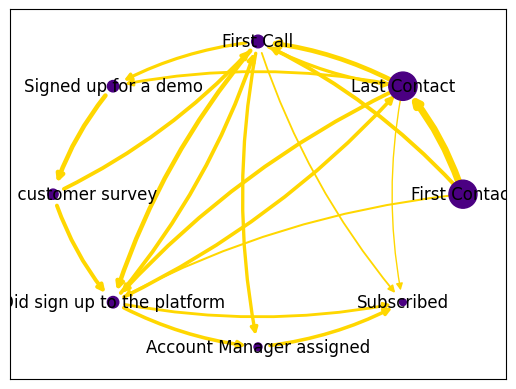

In [43]:
num_users_in_stage_raw = (~pd.isnull(df_order[date_columns])).sum()
non_last_state_count_raw = connection_matrix_raw.sum(axis="columns")
last_state_count = num_users_in_stage_raw - non_last_state_count_raw
non_last_state_count_clean = connection_matrix_clean.sum(axis="columns")
num_users_in_stage = last_state_count + non_last_state_count_clean

node_data = pd.DataFrame(num_users_in_stage.rename("weight"))
node_data = [(node, {"weight": weight}) for node, (weight,) in node_data.iterrows()]
G = nx.DiGraph()
G.add_nodes_from(node_data)
G.add_weighted_edges_from(list(connection_matrix_clean.stack()[connection_matrix_clean.stack() > 0].reset_index().itertuples(index=False, name=None)))
draw_network(G)

From the graph there is one thing that is pretty clear: the process does not follow the same sequence in all cases. Some funnels are pretty simple, even completely sequential, but in this company there are many possibilities. One can sign up for a demo just after the last contact, but also after the first call. And an account manager han be assigned after the call, but also after signing up to the platform.

It is this variety that will allow for the optimization of the process.

# Create environment

In reinforcement learning, there is an agent that acts on a scenario. From the actions it takes, the scenario returns some rewards and the state changes. The agent uses this information to learn what actions yield the highest accumulated reward.

The agent is going to take the role of the company, which must act in a way or another to achieve the subscription of users (the reward). The scenario is all the information available about the user and his funnel journey up until the moment of taking the next action.

But what are the actions the agent can take. In other words, what are the actions the company can take in order to move the process forward?

Each transition between two states is either product of two things: the user took an action, or the company took an action.

TO BE COMPLETED

## Test environment class

In [17]:
from tests.test_flow_environment import EnvironmentTests

In [18]:
%autoreload 2
import unittest

suite = unittest.TestLoader().loadTestsFromTestCase(EnvironmentTests)
runner = unittest.TextTestRunner()
runner.run(suite)

.....................................
----------------------------------------------------------------------
Ran 37 tests in 0.045s

OK


<unittest.runner.TextTestResult run=37 errors=0 failures=0>

## Create graph from edge information

Calculate graph from matrix

In [19]:
connection_matrix = add_terminated_and_origin_states_to_connection_matrix(connection_matrix_clean, num_users_in_stage)

From the non-zero values of the matrix you define the existing edges, from the index states to the column states.
The values are the weights.
Then you define which transitions are automatic and which require an action and what action.

Add actions and rewards

In [20]:
action_edges = [
    ("First Contact", "Last Contact", "Contact", -1),
    ("First Call", "Signed up for a demo", "Propose Demo", -1),
    ("Did sign up to the platform", "Last Contact", "Contact", -1),
    (slice(None), "Account Manager assigned", "Assign Account Manager", -10),
    (slice(None), "Terminated", "Automatic", -10),
    (slice(None), "Subscribed", "Automatic", 50),
]

In [21]:
edge_information = create_edge_information(connection_matrix, action_edges)

Compute graph

In [22]:
terminal_states = ["Terminated", "Subscribed"]

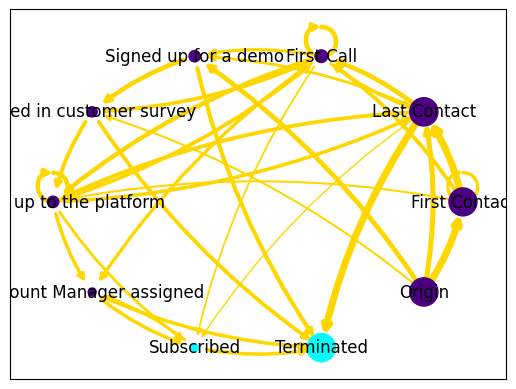

In [23]:
G = edge_info_to_graph(edge_information, num_users_in_stage, terminal_states)
draw_network(G)

# Training

Create environment

In [24]:
env = UserFlowEnvironment(
    G,
    "Origin",
    ["Contact", "Propose Demo", "Assign Account Manager"],
    render_mode="human"
)

In [25]:
check_env(env, warn=True)

Test environment

action: 2
defaultdict(<class 'list'>, {None: ['Origin', 'First Contact', 'First Call', 'Did sign up to the platform', 'Did sign up to the platform'], 'Assign Account Manager': ['Account Manager assigned', 'Subscribed']})
Episode:1 Score:40. Terminated: True. Truncated: False
action: 1
defaultdict(<class 'list'>, {None: ['Origin', 'Signed up for a demo', 'Terminated']})
Episode:2 Score:0. Terminated: True. Truncated: True
action: 0
defaultdict(<class 'list'>, {None: ['Origin', 'First Contact', 'First Call', 'First Call']})
Episode:3 Score:0. Terminated: False. Truncated: True
action: 2
defaultdict(<class 'list'>, {None: ['Origin', 'First Contact', 'First Call', 'First Call'], 'Assign Account Manager': ['Account Manager assigned', 'Subscribed']})
Episode:4 Score:40. Terminated: True. Truncated: False
action: 1
defaultdict(<class 'list'>, {None: ['Origin', 'First Contact', 'First Call', 'Did sign up to the platform', 'Did sign up to the platform']})
Episode:5 Score:0. Terminated: False. T

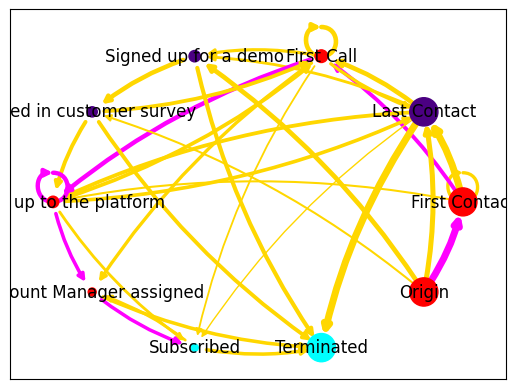

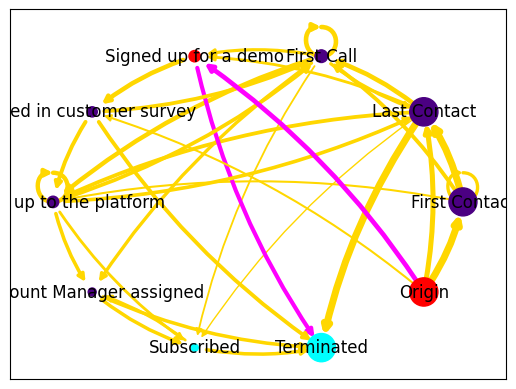

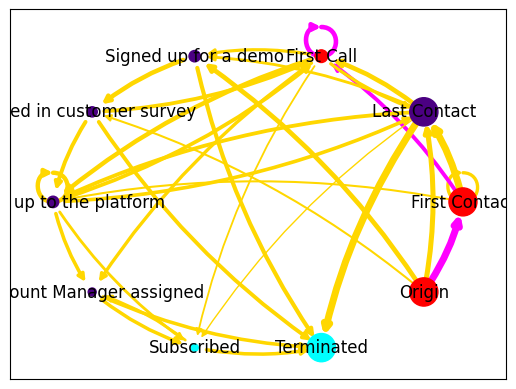

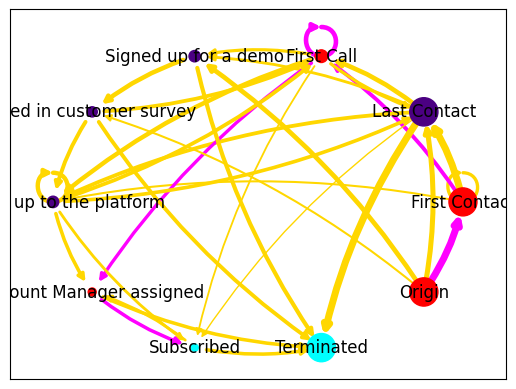

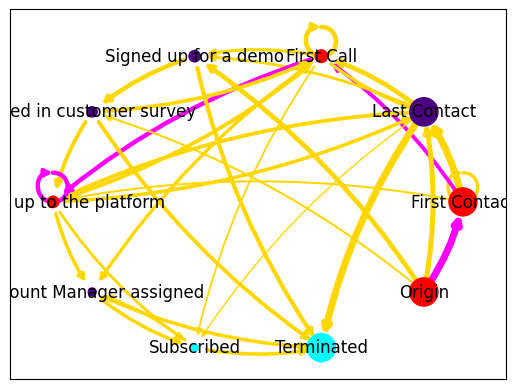

In [26]:
episodes = 5
for episode in range(1, episodes+1):
    state = env.reset()
    terminated = False
    truncated = False
    score = 0 
    
    while not terminated and not truncated:
        action = env.action_space.sample()
        print(f"action: {action}")
        state, reward, terminated, truncated, info = env.step(action)
        print(info)
        score += reward
    env.render()
    print('Episode:{} Score:{}. Terminated: {}. Truncated: {}'.format(episode, score, terminated, truncated))
env.close()

Train

In [27]:
log_path = Path("data/training/logs")
log_path.mkdir(parents=True, exist_ok=True)

In [28]:
model = PPO("MlpPolicy", env, verbose=0, tensorboard_log=log_path)

/anaconda/envs/salesreinforcercondavenv/lib/python3.10/site-packages/torch/cuda/__init__.py:138: UserWarning:

CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)



In [29]:
model.learn(total_timesteps=10000)

In [30]:
evaluate_policy(model, env, n_eval_episodes=1, return_episode_rewards=True)

/anaconda/envs/salesreinforcercondavenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning:

Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.



([-20.0], [1])

In [31]:
from azureml.tensorboard import Tensorboard

# The TensorBoard constructor takes an array of jobs, so be sure and pass it in as a single-element array here
tb = Tensorboard([], local_root=log_path, port=6006)

# If successful, start() returns a string with the URI of the instance.
tb.start()

https://rubchume1-6006.westeurope.instances.azureml.ms


'https://rubchume1-6006.westeurope.instances.azureml.ms'

Test model with individual iterations

In [32]:
def perform_episode(model, environment):
    obs, info = environment.reset()
    terminated = False
    truncated = False
    actions = []
    while not terminated and not truncated:
        action, states = model.predict(obs)
        actions.append(action)
        obs, rewards, terminated, truncated, info = environment.step(action)
        print(rewards)
    print(f"terminated: {terminated}")
    print(f"truncated: {truncated}")
    print(info)
    environment.render()
    
    return info, actions

0
terminated: True
truncated: True
defaultdict(<class 'list'>, {None: ['Origin', 'First Contact', 'First Call', 'Last Contact', 'Terminated']})
0
terminated: False
truncated: True
defaultdict(<class 'list'>, {None: ['Origin', 'First Contact', 'First Contact']})
-1
-20
terminated: True
truncated: False
defaultdict(<class 'list'>, {None: ['Origin', 'First Contact', 'First Call', 'First Call'], 'Propose Demo': ['Signed up for a demo', 'Filled in customer survey', 'Did sign up to the platform', 'Did sign up to the platform'], 'Assign Account Manager': ['Account Manager assigned', 'Terminated']})


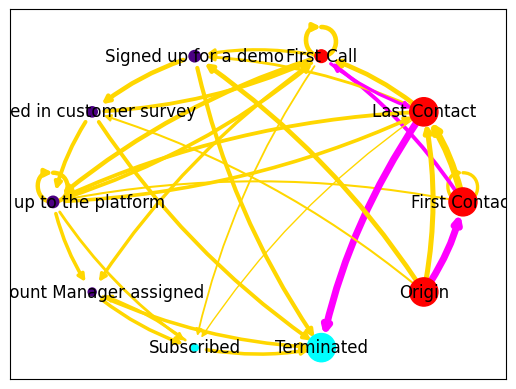

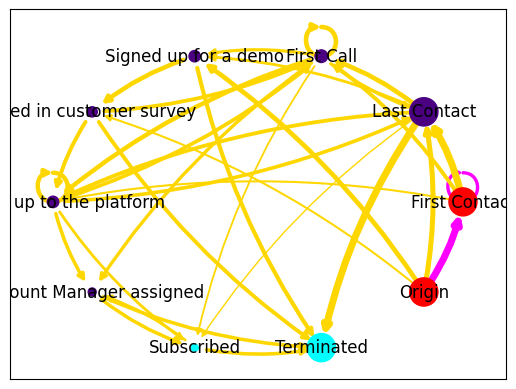

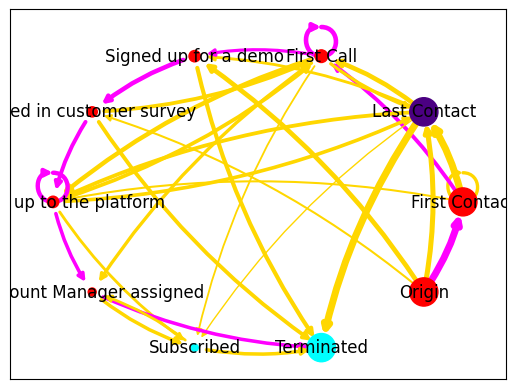

In [33]:
infos = [perform_episode(model, env) for _ in range(3)]

In [34]:
import itertools


iteration_visited_nodes = [
    set(itertools.chain.from_iterable(info.values()))
    for info in infos
]

AttributeError: 'tuple' object has no attribute 'values'

In [ ]:
df_order_evaluation = pd.DataFrame([
    connection_matrix.columns.map({
        state: order
        for order, state in pd.Series(itertools.chain.from_iterable(info.values())).drop_duplicates(ignore_index=True).items()
    }) for info in infos
], columns=connection_matrix.columns)

In [ ]:
connection_matrix_evaluation

In [ ]:
connection_matrix_evaluation = compute_connection_matrix(df_order_evaluation)
create_edge_information(connection_matrix_evaluation, action_edges)